In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath("../"))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import matplotlib.pyplot as plt
import glob


from musik import *
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import open3d as o3d
from utils import phantom_builder

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:
voxel_size = np.array([0.001, 0.001, 0.001])
# voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(
    f"{parent}/assets/cardiac_TEE_phantom/esophageal_surface.ply"
)
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)

In [3]:
test_phantom = phantom.Phantom(
    voxel_dims=(voxel_size[0], voxel_size[0], voxel_size[0]),
    matrix_dims=body_mask.shape,
    baseline=(1540, 1000),
    seed=None,
)

blood = tissue.Tissue(name="blood", c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(
    name="myocardium", c=1592, rho=1081, sigma=20, scale=0.0001, label=2
)
esophagus = tissue.Tissue(
    name="esophagus", c=1500, rho=1100, sigma=10, scale=0.0001, label=3
)
fat = tissue.Tissue(name="fat", c=1480, rho=970, sigma=15, scale=0.0001, label=4)

heart_file_dir = f"{parent}/assets/cardiac_TEE_phantom"

heart_tissue_list = [blood, myocardium, esophagus]

test_phantom.build_organ_from_mesh(
    surface_mesh, voxel_size[0], heart_tissue_list, dir_path=heart_file_dir
)
test_phantom.set_default_tissue(fat)

Added blood
Added myocardium
Added esophagus


In [4]:
test = test_phantom.get_complete()

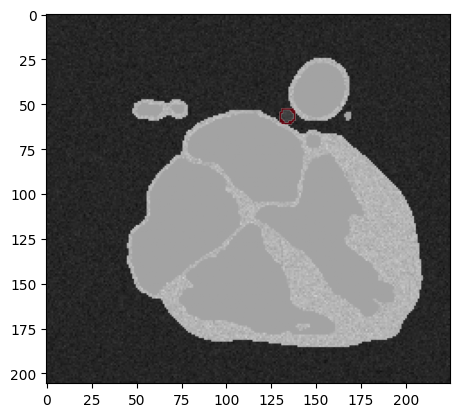

In [5]:
index = 100
plt.imshow(test[0, :, :, index], cmap="gray", vmin=1450, vmax=1650)
plt.imshow(
    body_mask[:, :, index], alpha=(body_mask[:, :, index] > 0) * 0.9, cmap="Reds"
)

# Set up simulation

### Test

In [6]:
num_transducers = 2     # 1000, 3000
transducers = [
    transducer.Focused(
        max_frequency=0.5e6,   # changed, 0.8e6
        elements=128,
        width=20e-3,
        height=20e-3,
        sensor_sampling_scheme="not_centroid",
        sweep=np.pi / 2,    # np.pi / 2,
        ray_num=16,    # changed, 64
        imaging_ndims=2,
        focus_azimuth=100e-3,
        focus_elevation=150e-3,
        cycles=3,
    )
    for i in range(num_transducers)
]


for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)


In [7]:
transform = geometry.Transform([0.3,-0.2,0.2], [-0.08,0,0])
test_transducer_set.assign_pose(0, transform)

transform = geometry.Transform([0.3,-0.2,0.2+np.pi], [-0.08,0,0])
test_transducer_set.assign_pose(1, transform)

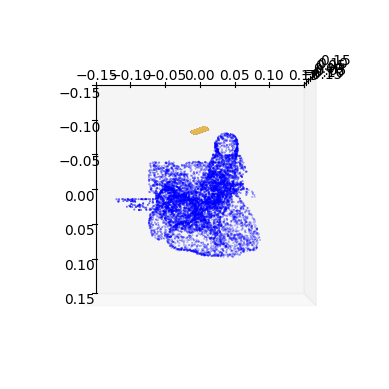

In [8]:
# test plot
# points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/cardiac_TEE_phantom/02_myocardium.obj")).sample_points_uniformly(5000).points)
points = np.array(
    (o3d.io.read_triangle_mesh(f"/{parent}/assets/cardiac_TEE_phantom/01_bloodpool.obj"))
    .sample_points_uniformly(8000)
    .points
)

test_transducer_set.plot_transducer_coords(
    scale=0.15, phantom_coords=points, view=(90, 0)
)
# test_transducer_set.plot_transducer_coords(
#     scale=0.15, phantom_coords=points, view=(0, 0)
# )
# test_transducer_set.plot_transducer_coords(
#     scale=0.15, phantom_coords=points, view=(0, 90)
# )

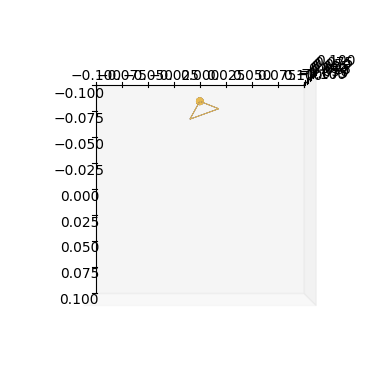

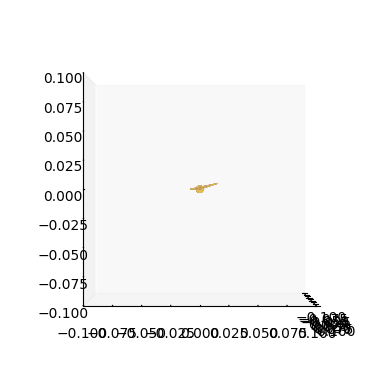

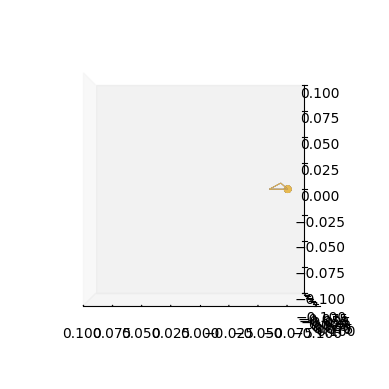

In [9]:
test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(90, 0))
test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(0, 0))
test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(0, 90))

### Original Code

In [10]:
test_sensor = sensor.Sensor(
    transducer_set=test_transducer_set, aperture_type="transmit_as_receive"
)

In [11]:
simprops = simulation.SimProperties(
    grid_size=(200e-3, 25e-3, 25e-3),
    voxel_size=(0.5e-3, 0.5e-3, 0.5e-3),
    PML_size=(16, 16, 16),
    PML_alpha=2,
    t_end=12e-5,  # [s]
    bona=6,  # parameter b/a determining degree of nonlinear acoustic effects
    alpha_coeff=0.5,  # [dB/(MHz^y cm)]
    alpha_power=1.5,
)

In [16]:
test_experiment = experiment.Experiment(
    simulation_path=f"TTE_test",
    sim_properties=simprops,
    phantom=test_phantom,
    transducer_set=test_transducer_set,
    sensor=test_sensor,
    nodes=1,
    results=None,
    indices=None,
    workers=4,
    additional_keys=[],
)

test_experiment.save()
test_experiment = experiment.Experiment.load(f"TTE_test")

workers is the number of simulations being prepared simultaneously on a single gpu node. Having many workers is RAM intensive and may not decrease overall runtime


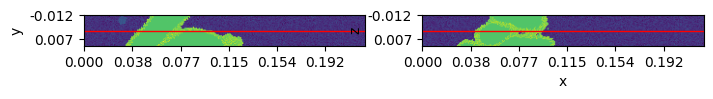

In [17]:
test_experiment.plot_ray_path(8)

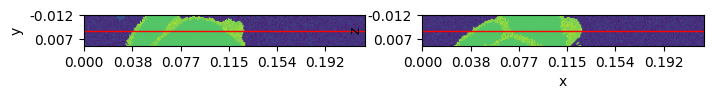

In [18]:
test_experiment.plot_ray_path(7)

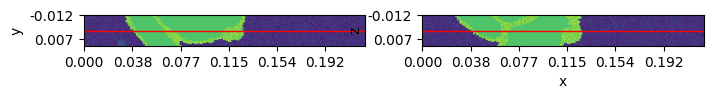

In [20]:
test_experiment.plot_ray_path(24)

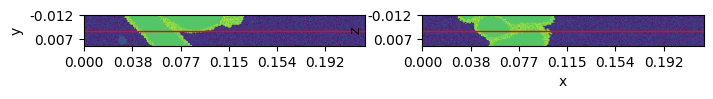

In [19]:
test_experiment.plot_ray_path(23)

# Run Simulation

In [21]:
test_experiment = experiment.Experiment.load(f"TTE_test")
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00, 96.34it/s]


In [ ]:
test_experiment.run(repeat=False)

running with 4 workers

preparation for sim    0 completed in  5.34 seconds
preparation for sim    1 completed in  5.72 seconds
preparation for sim   11 completed in  5.33 seconds
preparation for sim    2 completed in  5.27 seconds
simulation             0 completed in  4.42 seconds
simulation            11 completed in  4.43 seconds
preparation for sim   12 completed in  5.39 seconds
preparation for sim    3 completed in  5.45 seconds
simulation             1 completed in  4.70 seconds
preparation for sim   22 completed in  5.64 seconds
preparation for sim   13 completed in  5.87 seconds
simulation             2 completed in  4.45 seconds
simulation            12 completed in  4.23 seconds
simulation             3 completed in  4.45 seconds
preparation for sim   23 completed in  5.67 seconds
preparation for sim   14 completed in  5.59 seconds
preparation for sim    4 completed in  5.53 seconds
simulation            22 completed in  4.66 seconds
preparation for sim   24 completed in  5

# Reconstruction

In [23]:
test_experiment.add_results()

In [24]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [25]:
signals = test_reconstruction.get_signals(
    dimensions=2, matsize=512, downsample=1, workers=16, tgc=20
)

100%|██████████| 32/32 [00:22<00:00,  1.44it/s]
2it [00:00,  2.03it/s]


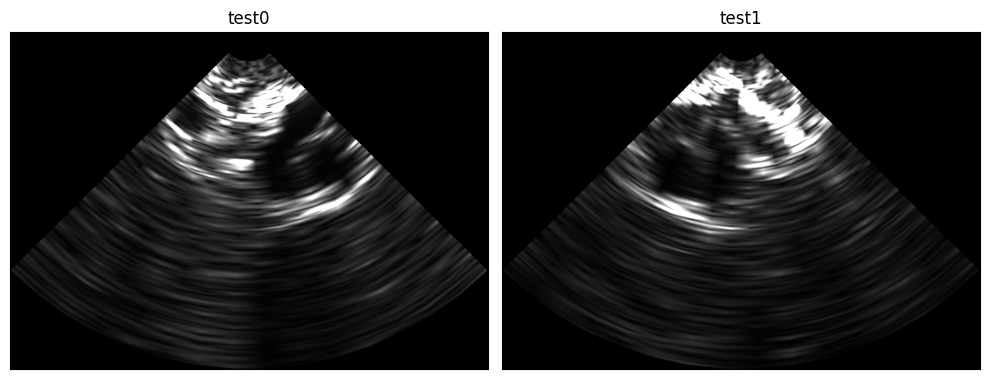

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # 1 row, 2 columns

# --- Image 1: apical 4-chamber ---
axes[0].imshow(signals[0][:, ::-1], vmin=0, vmax=50000, cmap="gray")
axes[0].set_title("test0")
axes[0].set_facecolor("black")
axes[0].set_xticks([])
axes[0].set_yticks([])

# --- Image 2: apical 2-chamber ---
axes[1].imshow(signals[1][:, ::-1], vmin=0, vmax=50000, cmap="gray")
axes[1].set_title("test1")
axes[1].set_facecolor("black")
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

# plt.imshow(signals[2][:, ::-1], vmin=0, vmax=100000, cmap="gray")
# plt.gca().set_facecolor("black")
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.savefig(
#     "cardiac_TTE_parasternal_sax_midpap_2MHz.png",
#     bbox_inches="tight",
#     pad_inches=0,
#     dpi=300,
# )
# plt.title("cardiac_TTE_parasternal_sax_midpap")
# plt.show()

# plt.imshow(signals[3][:, ::-1], vmin=0, vmax=100000, cmap="gray")
# plt.gca().set_facecolor("black")
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.savefig(
#     "cardiac_TTE_parasternal_sax_mitral_2MHz.png",
#     bbox_inches="tight",
#     pad_inches=0,
#     dpi=300,
# )

# plt.imshow(signals[4][:, ::-1], vmin=0, vmax=100000, cmap="gray")
# plt.gca().set_facecolor("black")
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.savefig(
#     "cardiac_TTE_parasternal_lax_2MHz.png", bbox_inches="tight", pad_inches=0, dpi=300
# )

# plt.imshow(signals[5][:, ::-1], vmin=0, vmax=100000, cmap="gray")
# plt.gca().set_facecolor("black")
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.savefig(
#     "cardiac_TTE_subcostal_4ch_2MHz.png", bbox_inches="tight", pad_inches=0, dpi=300
# )

In [54]:
P0 = test_transducer_set.get_poses()[0].rotation.as_matrix()
P1 = test_transducer_set.get_poses()[1].rotation.as_matrix()

print(P0)
print(P1)

[[ 0.93629336 -0.32733613 -0.12730197]
 [ 0.28962948  0.92462933 -0.24733656]
 [ 0.19866933  0.19470917  0.9605305 ]]
[[ 0.93629336  0.32733613  0.12730197]
 [ 0.28962948 -0.92462933  0.24733656]
 [ 0.19866933 -0.19470917 -0.9605305 ]]


In [ ]:
## For EXTRINSIC composition, left multiply
# T = P0 @ P1.T
# For INTRINSIC composition, right multiply
T = P0.T @ P1

print(T.round(3))

[[ 1.  0. -0.]
 [ 0. -1.  0.]
 [ 0. -0. -1.]]


In [69]:
P1.round(7) == (P0 @ T).round(7)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [48]:
test_transducer_set.get_poses()[0].rotation.as_euler('ZYX')

array([ 0.3, -0.2,  0.2])

In [49]:
test_transducer_set.get_poses()[1].rotation.as_euler('ZYX')

array([ 0.3       , -0.2       , -2.94159265])